In [1]:
# Import Library
import json
from pathlib import Path
import re
import random
import spacy
from spacy.training.example import Example
from PIL import Image
import matplotlib.pyplot as plt

# Atur path dataset
box_dir = Path("Dataset/train/box")
entities_dir = Path("Dataset/train/entities")

# Ambil file
box_files = list(box_dir.glob("*.txt"))
entities_files = list(entities_dir.glob("*.txt"))

print(f"Jumlah file box: {len(box_files)}")
print(f"Jumlah file entity: {len(entities_files)}")


Jumlah file box: 626
Jumlah file entity: 626


In [2]:

def clean_text(text):
    return re.sub(r"\s+", " ", text.strip().lower())


def find_entity_spans(full_text, labels):
    entities = []
    for key, val in labels.items():
        val_clean = clean_text(val)
        start = full_text.find(val_clean)
        if start != -1:
            end = start + len(val_clean)
            entities.append((start, end, key.upper()))
    return entities


In [3]:
train_data = []

for box_path in box_files:
    with open(box_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        words = [line.strip().split(",")[-1] for line in lines if line.strip()]
        full_text = clean_text(" ".join(words))

        for entity_path in entities_files:
            with open(entity_path, "r", encoding="utf-8") as ef:
                try:
                    entity_data = json.loads(ef.read())
                except:
                    continue
                entities = find_entity_spans(full_text, entity_data)
                if len(entities) == 4:
                    train_data.append((full_text, {"entities": entities}))
                    break

print(f"Total data pelatihan: {len(train_data)}")


Total data pelatihan: 23


In [4]:
# Acak data agar pelatihan lebih merata
random.shuffle(train_data)


nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")

# Tambahkan label entitas
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])


In [ ]:
# training
optimizer = nlp.begin_training()
for epoch in range(50):
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.3, losses=losses)
    print(f"Epoch {epoch+1} | Loss: {losses['ner']:.4f}")


Epoch 1 | Loss: 1144.0225
Epoch 2 | Loss: 175.8811
Epoch 3 | Loss: 218.5965
Epoch 4 | Loss: 269.1240
Epoch 5 | Loss: 317.8970
Epoch 6 | Loss: 943.4911
Epoch 7 | Loss: 152.2375
Epoch 8 | Loss: 95.6610
Epoch 9 | Loss: 70.9854
Epoch 10 | Loss: 49.1708
Epoch 11 | Loss: 53.7365
Epoch 12 | Loss: 27.0772
Epoch 13 | Loss: 43.2733
Epoch 14 | Loss: 34.0453
Epoch 15 | Loss: 25.2779
Epoch 16 | Loss: 19.5939
Epoch 17 | Loss: 31.7925
Epoch 18 | Loss: 25.7437
Epoch 19 | Loss: 26.5749
Epoch 20 | Loss: 17.7196
Epoch 21 | Loss: 17.4437
Epoch 22 | Loss: 7.2230
Epoch 23 | Loss: 13.0540
Epoch 24 | Loss: 18.7527
Epoch 25 | Loss: 77.8919
Epoch 26 | Loss: 27.1700
Epoch 27 | Loss: 12.5623
Epoch 28 | Loss: 7.4522
Epoch 29 | Loss: 7.7425
Epoch 30 | Loss: 47.4735
Epoch 31 | Loss: 26.9805
Epoch 32 | Loss: 5.5492
Epoch 33 | Loss: 16.5956
Epoch 34 | Loss: 10.1961
Epoch 35 | Loss: 7.6812
Epoch 36 | Loss: 2.2787
Epoch 37 | Loss: 6.7515
Epoch 38 | Loss: 9.3752
Epoch 39 | Loss: 9.6676
Epoch 40 | Loss: 8.8063
Epoch 41 | 

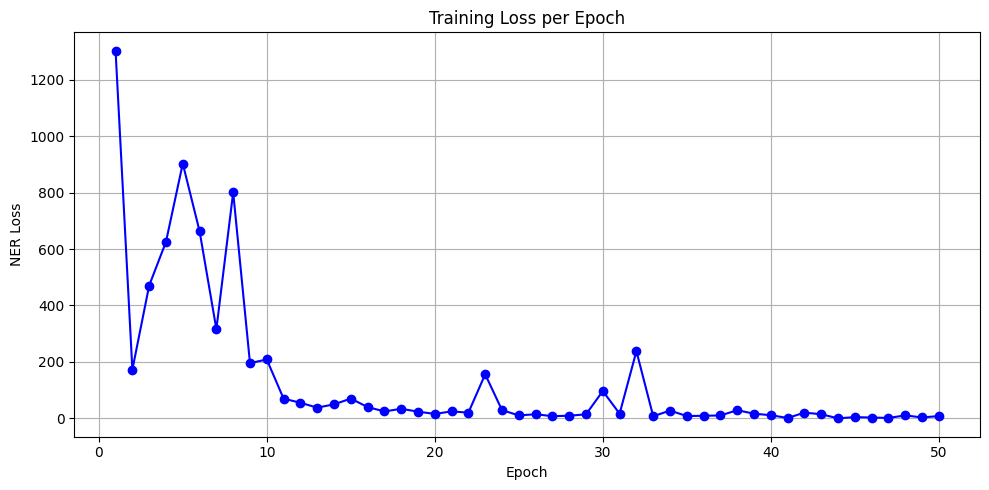

In [5]:
import matplotlib.pyplot as plt
from spacy.training.example import Example

# Inisialisasi training
optimizer = nlp.begin_training()
losses_per_epoch = []

for epoch in range(50):
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.3, losses=losses)
    
    ner_loss = losses.get("ner", 0)
    losses_per_epoch.append(ner_loss)

# Visualisasi grafik Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), losses_per_epoch, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("NER Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# Simpan model
output_dir = Path("receipt_ner_model")
nlp.to_disk(output_dir)
print(f" Model disimpan ke: {output_dir.resolve()}")


 Model disimpan ke: D:\Projects\Financial Tracking Web\receipt_ner_model


In [48]:
# Load model
nlp2 = spacy.load("receipt_ner_model")

# Coba prediksi teks dari salah satu data training
test_text = train_data[2][0]
doc = nlp2(test_text)

print("Text:", test_text)
print("Entities:")
for ent in doc.ents:
    print(f"{ent.label_}: {ent.text}")


Text: ikano handel sdn bhd (1074617k) ikea cheras no 2a jalan cochrane taman maluri 55100 kuala lumpur gst no.: 000115154944 tax invoice slip: 0000000011000140428 date: 09/08/17 time: 1:06 trans: 311140123 staff: 96728 description amount tx 30169728 bagis coat-hanger ch 2 pc @ 4.90 9.80 srm 70350938 teodores ch 90.00 sr s total rm including gst 6% 99.80 rounding adj. 0.00 total rounded 99.80 mastercard -99.80 gst sr 6% 99.80 5.64 amt. excl. gst 94.16 no. of items 3 thank you. please come again. *t3620000011000140428*
Entities:
COMPANY: ikano handel sdn bhd
ADDRESS: no 2a jalan cochrane taman maluri 55100 kuala lumpur
DATE: 09/08/17
TOTAL: 99.80


In [49]:
!python -m spacy evaluate receipt_ner_model ./test.spacy

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   88.89 
NER R   80.00 
NER F   84.21 
SPEED   8771  


=============================== NER (per type) ===============================

               P        R        F
COMPANY   100.00    60.00    75.00
ADDRESS    60.00    60.00    60.00
DATE      100.00   100.00   100.00
TOTAL     100.00   100.00   100.00

